In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import util
import pfilter
from scipy.stats import norm

import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
!pwd

/home/zpyang/git/visnet/src/visnet/notebooks


In [2]:
class Camera:
    def __init__(self, cam_param, cam_pos, cam_att):
        self.param = cam_param
        self.pos = cam_pos
        self.att = cam_att
        self.K = util.get_cam_in(self.param)
        self.R = util.R_model2cam @ util.so3_exp(self.att)
        self.P = util.get_cam_mat_lie(self.param, self.pos, self.att)
#         self.measurements = []
        
    def __repr__(self):
        return "param: {}, pos: {}, att: {}".format(self.param, self.pos, self.att)
        
    def _get_pixel_pos_hom(self, target_pos):
        return self.P @ util.cart2hom(target_pos)
    
    def _get_pixel_pos(self, target_pos):
        return util.hom2cart(self._get_pixel_pos_hom(target_pos))
    
    def add_pixel_noise(self, pixel_coord):
        return pixel_coord + np.random.normal(0, 20)
    
class CamNode(Camera):
    def _get_vec(self, pixel_pos):
        """
        Back projected ray from the camera to the target (approximate)
        """
        pixel_coord = self.add_pixel_noise(pixel_pos)
        K = self.K
        R = self.R
        Bp = np.linalg.inv(K @ R)
        vec = Bp @ util.cart2hom(pixel_pos).astype('int32') # cast to integer because actual pixels are discrete
        vec = vec/np.linalg.norm(vec)
        return vec
    
    def _get_distance(self, target_pos):
        """
        !!!Should not be used directly in estimation!!!
        """
        dist =  np.linalg.norm(target_pos-self.pos)
        return dist
    
    def get_measurement(self, target_pos):
        """
        Bearing measurements in pixel coordinate and range in meters 
        The input here is temporary until we have trained the neural net to actually identify targets
        """
        bearing = self._get_pixel_pos(target_pos)
        return bearing   
    

In [3]:
drone_coords = []
n_frames = 100
for i in range(n_frames):
    elapsed = i*0.1
    x = 20*np.sin(np.pi*elapsed)
    y = 20*np.cos(np.pi*elapsed)
    z = 20
    drone_coords.append([x,y,z])
drone_coords = np.array(drone_coords)

drone_coords_hom = np.hstack([drone_coords, np.ones((n_frames,1))])

cam_param = [642.0926, 642.0926, 1000.5, 1000.5,0]
# [x y z roll pitch yaw]
cam_poses = np.array([
    [20, 20, 12, 0, 0, -2.2],
    [20, -20, 12, 0, 0, 2.2],
    [-20, -20, 12, 0, 0, 0.7],
    [-20, 20, 12, 0, 0, -0.7],
])

cam_nodes = [CamNode(cam_param, poses[0:3], poses[3:6]) for poses in cam_poses]

for pos in drone_coords:
    for cam_node in cam_nodes:
        cam_node.get_measurement(pos)


$$
x_{k+1} = A x_k + w
$$
where 
$$
A = \begin{bmatrix}
I & dt \cdot I \\
0 & I \\
\end{bmatrix} \\
w = \begin{bmatrix}
0 \\ w_v \\
\end{bmatrix}
$$

In [9]:
def dynamics_d(x):
    """
    Discrete dynamics
    """
    dt = 1/10
    A = np.block([
        [np.eye(3), dt*np.eye(3)],
        [np.zeros((3,3)), np.eye(3)]
    ])
    w = np.block([np.zeros(3), np.random.normal(0, 1, 3)])
    x_1 = A @ x + w
    
    return x_1

def dynamics_c(x):
    """
    Double integrator and constant velocity
    """
    A = np.zeros((6,6))
    A[0:3,3:6] = np.eye(3)
    w = np.block([np.zeros(3), np.random.randn(3)])
    xd = A @ x + w
    return xd

def drone_traj_circle(t):
    x = 15*np.sin(2 * np.pi * 0.01 * t / 3)
    y = 10*np.cos(2 * np.pi * 0.01 * t / 3)
    z = 20
    return np.array([x,y,z])

def drone_traj_straight(t):
    max_dist = 30
    x = t * 0.1
    y = 0
    z = 20
    return np.array([x, y, z])

In [10]:
num_cam = 4
n = 500        # number of particles per step
d = 6          # states to estimate (pos & vel)
h = 2*num_cam  # states of observation (pixel coord * num of cams)

def observe_fn(x):
    """
    Parameters:
        x : all particles at a step
    Returns:
        observations/measurements from x using the camera projection matrix
    """
    msmt = []
    for xi in x:
        vec = []
        for node in cam_nodes:
            p = node.get_measurement(xi[0:3])
            vec = np.hstack([vec,p])
        msmt.append(vec)
    return np.array(msmt)/2000.0

def dynamics_fn(x):
    """
    Parameters:
        x : all particles at a step
    Returns:
        x1: propagated particles
    """
    x1 = []
    for xi in x:
        x1.append(dynamics_d(xi))
    return np.array(x1)

def prior_fn(n):
    pos_x = np.random.uniform(-20, 20, (n,1))
    pos_y = np.random.normal(-20, 20, (n,1))
    pos_z = np.random.normal(10, 25, (n,1))
    vel_x = np.random.normal(0, 1, (n,1))
    vel_y = np.random.normal(0, 1, (n,1))
    vel_z = np.zeros((n,1))
    particles = np.hstack([pos_x, pos_y, pos_z, vel_x, vel_y, vel_z])
    print(particles.shape)
    return particles


# def vec2coord(vec, dist):
#     v = vec
#     d = dist
#     theta = np.arctan2(v[1], v[0])
#     phi = np.arctan2(v[2], v[0]+v[1])
    
#     z = d * np.sin(phi)
#     x = d * np.cos(phi) * np.cos(theta)
#     y = d * np.cos(phi) * np.sin(theta)
#     return np.array([x,y,z])

In [19]:
pf = pfilter.ParticleFilter(
    prior_fn=prior_fn,
    observe_fn=observe_fn,
    dynamics_fn=dynamics_fn,
    n_particles=500,
    resample_fn = pfilter.residual_resample,
    weight_fn=lambda x, y: pfilter.squared_error(x, y, sigma=1)
)
particles = []
state = []
state_est = []

t_step = 300
for t in range(t_step):
    target_pos = drone_traj_circle(t)
    z = []
    for node in cam_nodes:
        z = np.hstack([z, node.get_measurement(target_pos)])
    pf.update(z/2000.0)
    
    particles.append(pf.particles)
    state_est.append(pf.map_state)
    state.append(target_pos)
#     print('h: ', pf.hypotheses)
#     print('z: ', z) 
#     print('min weights', np.min(pf.weight_fn(pf.hypotheses, z/1000)))
#     print(pf.weight_normalisation)
#     print(pf.weights)

particles = np.array(particles)
state = np.array(state)
state_est = np.array(state_est)
err = state-state_est[:,0:3]

(500, 6)


Text(0, 0.5, 'error[m]')

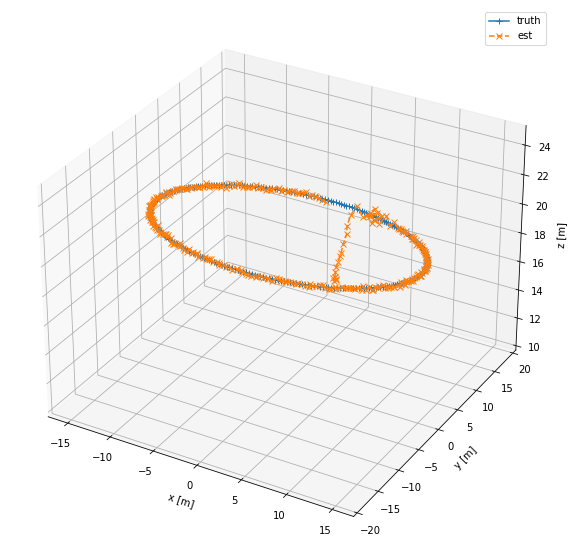

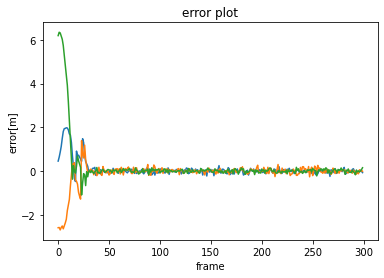

In [20]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
ax.plot3D(state[:,0], state[:,1], state[:,2], '+-', label='truth')
ax.plot3D(state_est[:,0], state_est[:,1], state_est[:,2], 'x--', label='est')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_ylim(-20,20)
ax.set_zlim(10, 25)
plt.legend()

plt.figure()
plt.plot(err)
plt.title('error plot')
plt.xlabel('frame')
plt.ylabel('error[m]')

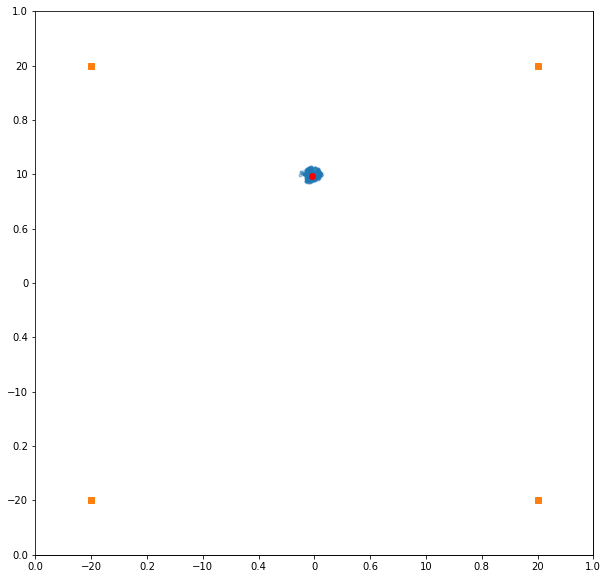

In [18]:
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))

axis = plt.axes(xlim=(-25, 25), ylim=(-25,25))

cloud, = axis.plot([], [], '.', alpha=0.2)
est, = axis.plot([], [], 'ro-')
cam_pos = axis.plot(cam_poses[:,0], cam_poses[:, 1], 's')
def init(): 
    cloud.set_data([], [])
    return cloud,

def animate(i):
    x = particles[i, :, 0]
    y = particles[i, :, 1]
    z = particles[i, :, 2]
    cloud.set_data(x, y)
    est.set_data(state_est[i, 0], state_est[i, 1])
    return cloud,

anim = FuncAnimation(fig, animate, init_func = init,
                     frames = t_step, interval = 100, blit = True)

HTML(anim.to_html5_video())